# Group Project Proposal

Group: 83
<br> Guozheng Gong, Brianna Zhou, Saakshith Manjunath, Hrishikesh Rakeshkumar Dalal

### Title

### Introduction:
According to the CDC, heart disease is one of the leading causes of death around the world. The most common risk factors that cause heart disease are high blood pressure and cholesterol (Heart disease and stroke). The NIH observed a linear association between a person’s heart rate and heart failure (Zhang et al.). Adults aged 65 and older are more at risk for diseases related to the heart than the youth (Heart health and aging). This is why we have chosen these variables as predictors for our data analysis. 

The column names are as follows:
- trestbps: resting blood pressure (in mm Hg on admission to the hospital)
- chol: serum cholesterol in mg/dl
- thalach: maximum heart rate achieved in beats each minute (bpm)
- age: age (in years)

Predictive question: Can we use blood pressure, cholesterol, heart rate and age to predict whether a person has heart disease or not?

We are using a dataset from the UCI Machine Learning Repository. The repository contains four databases about heart disease from four different places: Cleveland, Budapset, California, and Zurich. We will be using the Cleveland version of the database. 


### Preliminary exploratory data analysis:

In [1]:
library(tidyverse) #first run this to load package
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
download.file(url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", destfile = "data/processed.cleveland.data")
data <- read_csv(file = "data/processed.cleveland.data", col_names = c("age","sex","cp","trestbps","chol","fbs","restecg","thalach","exang","oldpeak","slope","ca","thal","num_the_predicted_attribute"))

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Because it says experiments with the Cleveland database have concentrated on simply attempting to distinguish presence (values 1,2,3,4) from absence (value 0), for this project, value 1,2,3,4 have the same meaning, so I make value 2,3,4 in num_the_predicted_attribute to be value 1.

In [3]:
data1 <- filter(data, num_the_predicted_attribute <=1)
data2 <- filter(data, num_the_predicted_attribute > 1)
data2 <- mutate(data2, num_the_predicted_attribute = 1)
data <- merge(data1, data2, all = T)
data <- mutate(data, num_the_predicted_attribute = as_factor(num_the_predicted_attribute))#change num_the_predicted_attribute to be factor

In [4]:
data <- select(data, age, trestbps ,chol,thalach, num_the_predicted_attribute)#Select the data we need

We choose 75% as training data.

In [5]:
data_split <- initial_split(data, prop = 0.75, strata = num_the_predicted_attribute) #split training data
data_train <- training(data_split)   
data_test <- testing(data_split)

We summary data for each variable's mean.

In [6]:
summary_data <- group_by(data_train,num_the_predicted_attribute) |>
    summarize(trestbps_mean = mean(trestbps), chol_mean = mean(chol),age_mean = mean(age),thalach_mean=mean(thalach), n=n())
summary_data

num_the_predicted_attribute,trestbps_mean,chol_mean,age_mean,thalach_mean,n
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
0,128.6667,244.4309,52.65854,158.7724,123
1,135.7019,246.2596,55.93269,138.3173,104


We count missing data in each column.

In [7]:
missing_data <- data_train %>%
    map_df(is.na) %>%
    map_df(sum)
missing_data

age,trestbps,chol,thalach,num_the_predicted_attribute
<int>,<int>,<int>,<int>,<int>
0,0,0,0,0


It looks like there is no missing data.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



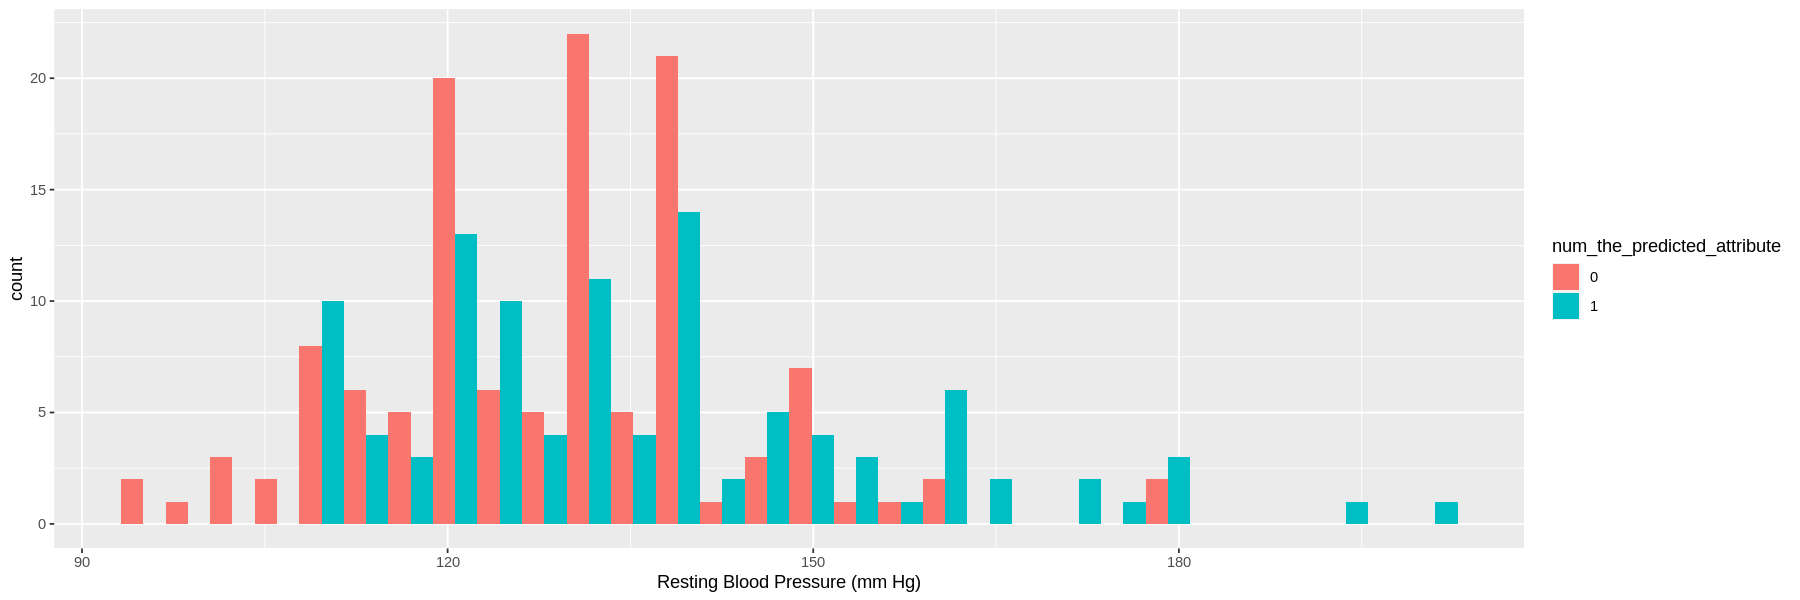

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



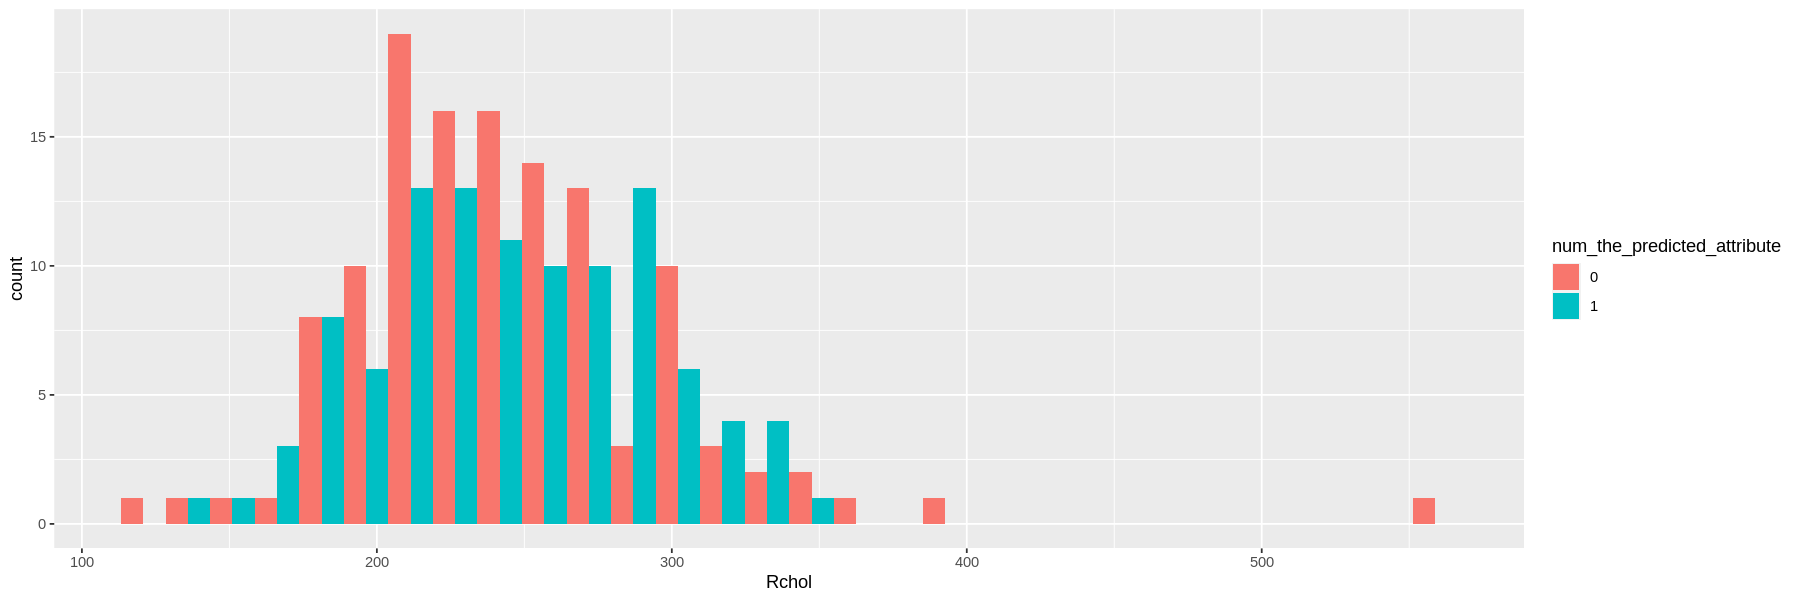

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



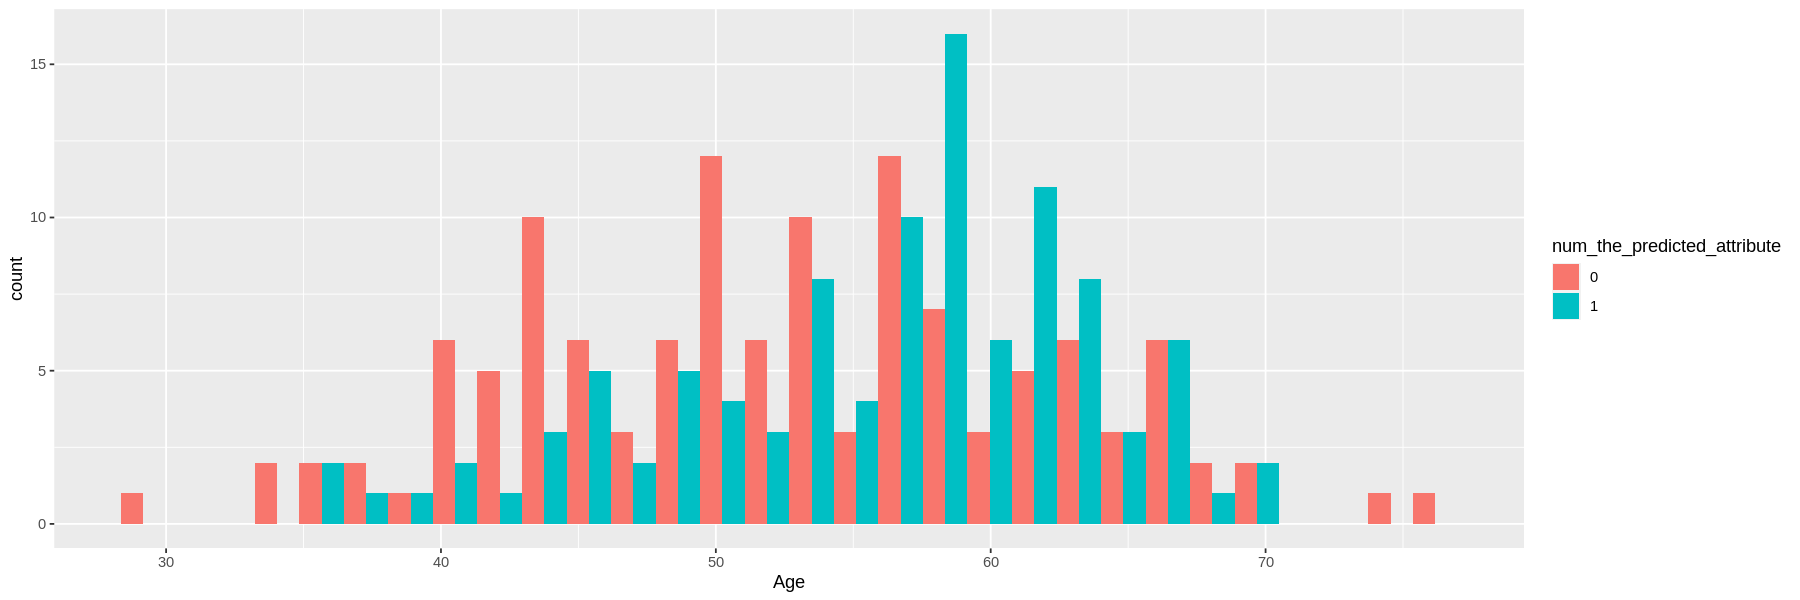

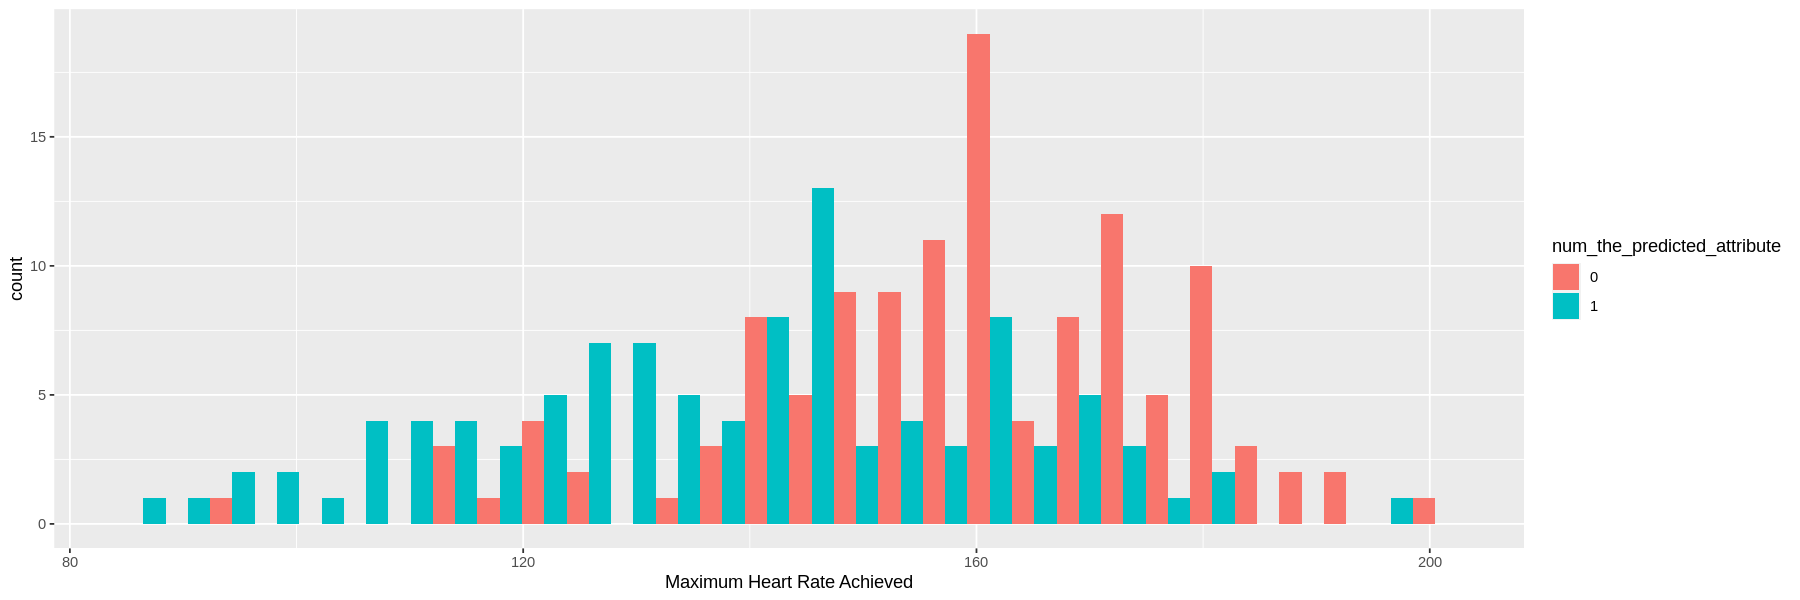

In [8]:
options(repr.plot.width = 15, repr.plot.height = 5) 
bp_plot <- ggplot(data_train, aes(x = trestbps, fill = num_the_predicted_attribute)) +
           geom_histogram(position = "dodge") +
           labs(x = "Resting Blood Pressure (mm Hg)", colour = "Predicted")          

bp_plot

chol_plot <- ggplot(data_train, aes(x = chol, fill = num_the_predicted_attribute)) +
           geom_histogram(position = "dodge") +
           labs(x = "Rchol", colour = "Predicted")          

chol_plot

age_plot <- ggplot(data_train, aes(x = age, fill = num_the_predicted_attribute)) +
           geom_histogram(position = "dodge") +
           labs(x = "Age", colour = "Predicted")          

age_plot

thalach_plot <- ggplot(data_train, aes(x = thalach, fill = num_the_predicted_attribute)) +
           geom_histogram(position = "dodge") +
           labs(x = "Maximum Heart Rate Achieved", colour = "Predicted")          

thalach_plot

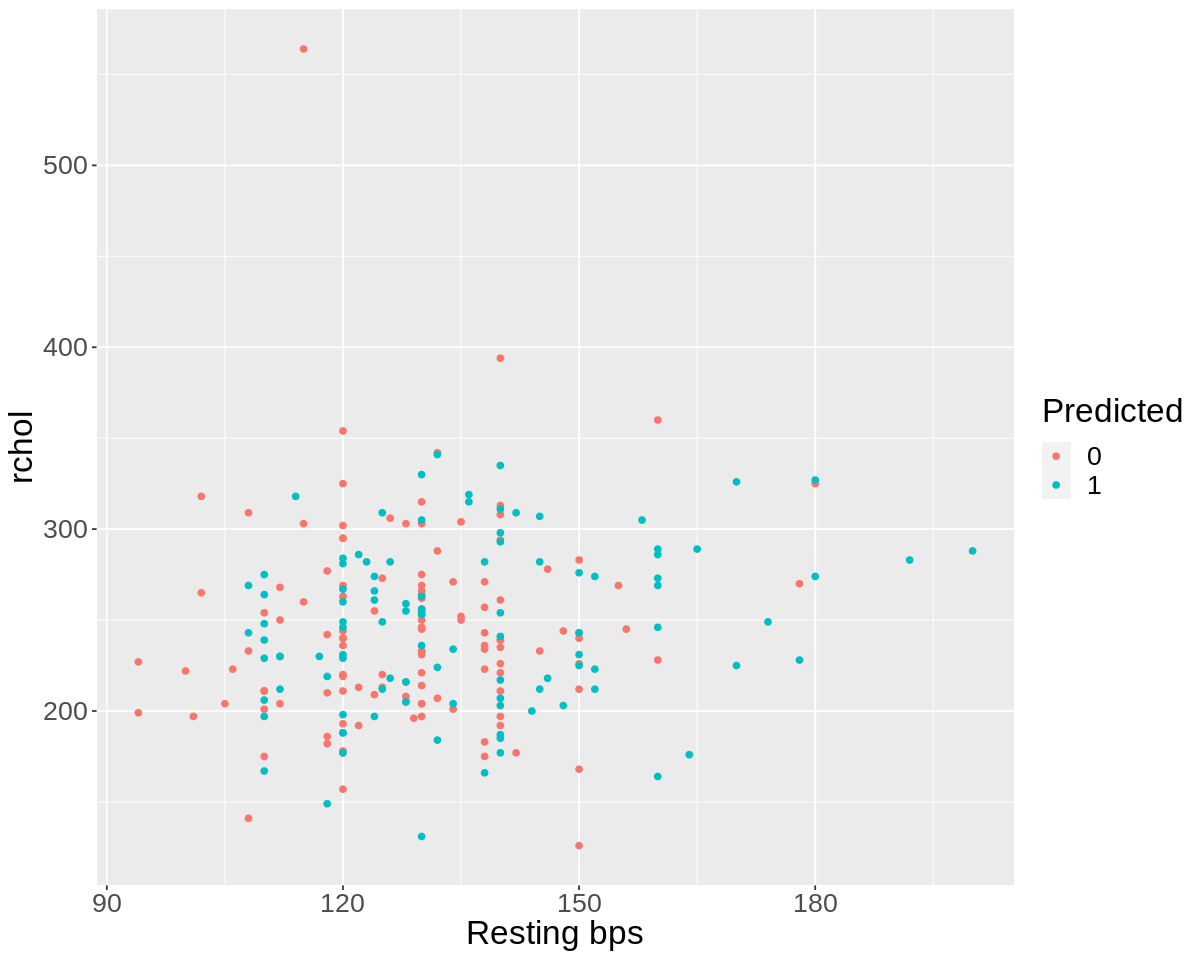

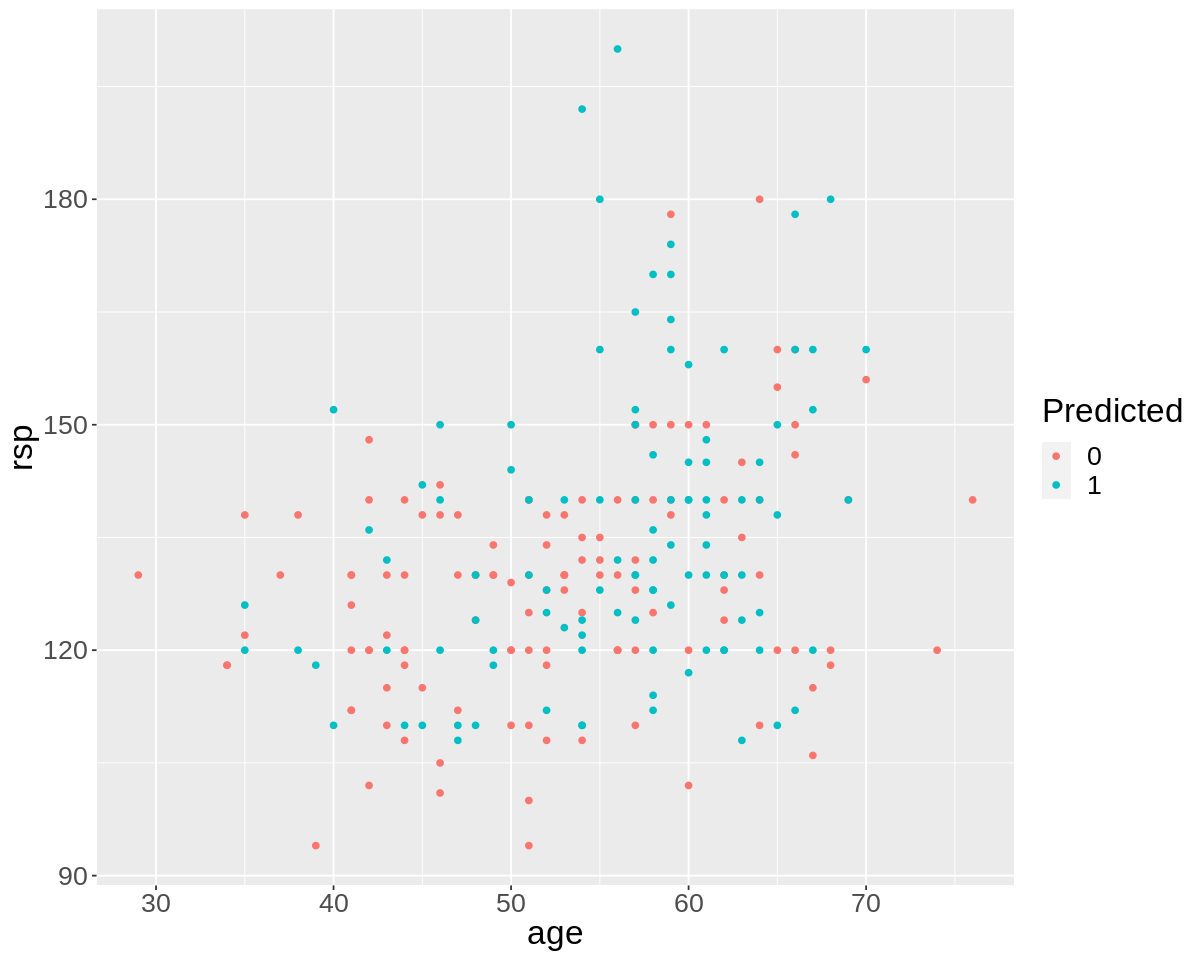

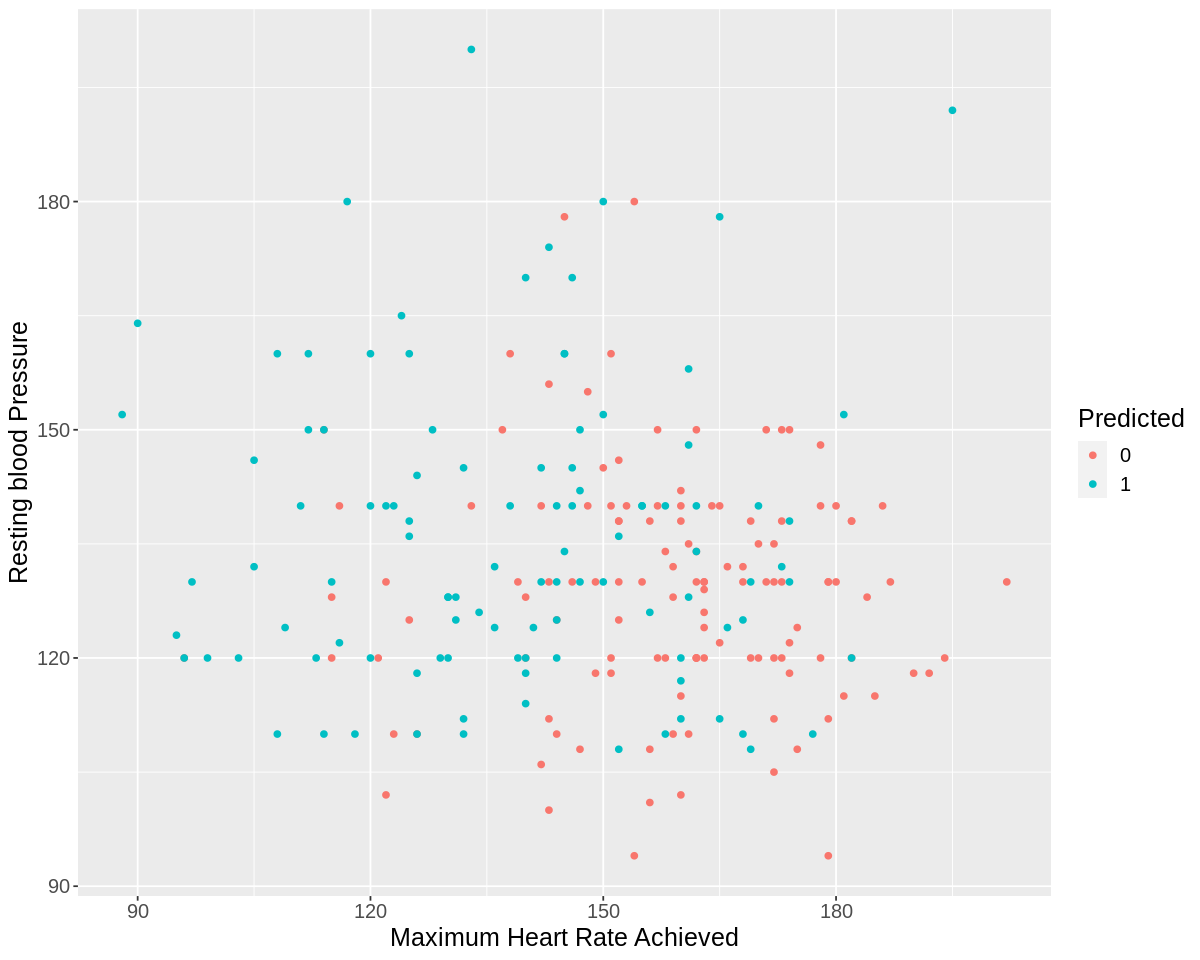

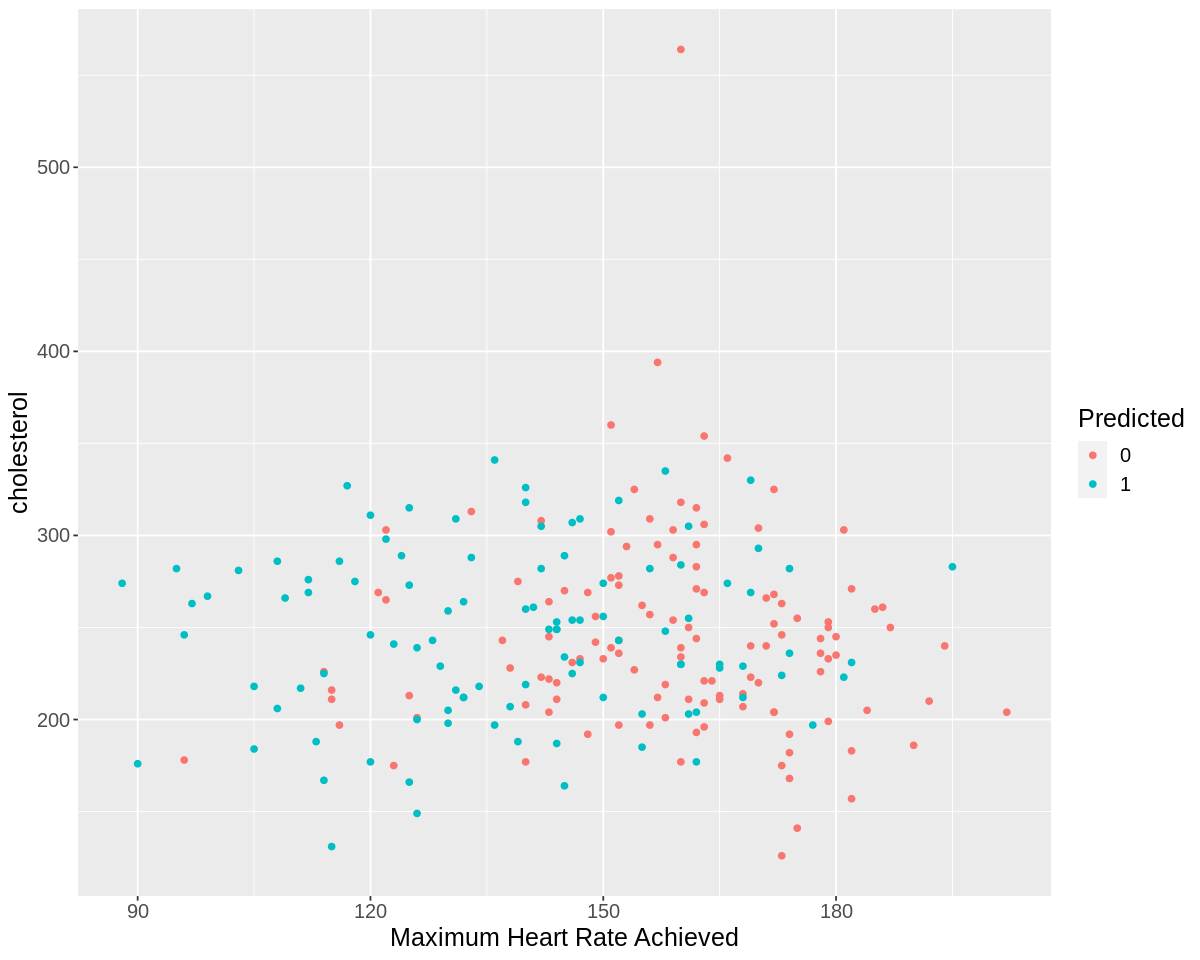

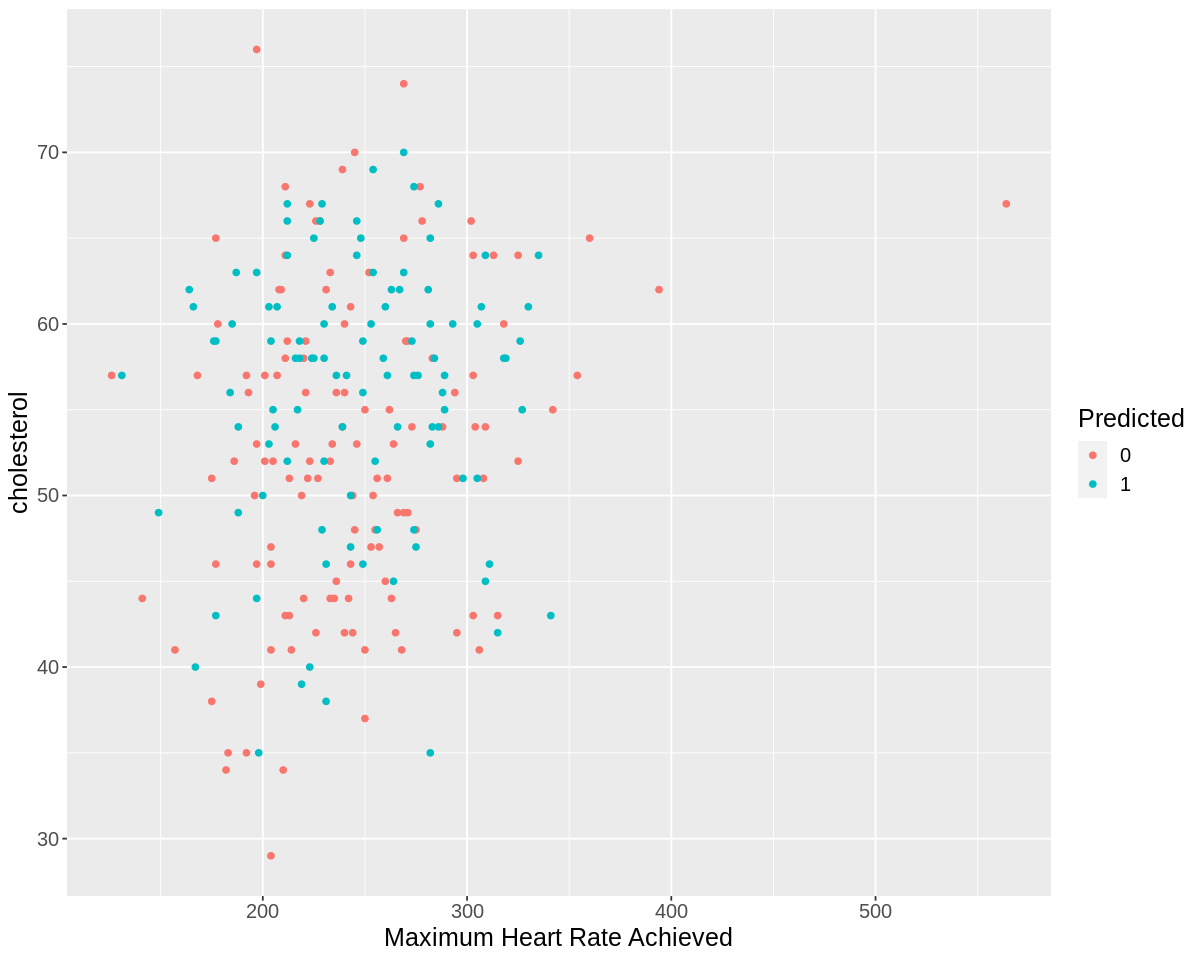

In [21]:
options(repr.plot.width = 10, repr.plot.height = 8) 

bp_plot <- data_train |>
ggplot(aes(x = trestbps, y = chol, colour = num_the_predicted_attribute)) +
geom_point() +
labs(x = "Resting bps", y = "rchol", colour = "Predicted") +
theme(text=element_text(size=20))

bp_plot

bp_aplot <- data_train |>
ggplot(aes(x = age, y = trestbps, colour = num_the_predicted_attribute)) +
geom_point() +
labs(x = "age", y = "rsp", colour = "Predicted") +
theme(text=element_text(size=20))

bp_aplot

bp_hplot <- data_train |>
ggplot(aes(x = thalach, y = trestbps, colour = num_the_predicted_attribute)) +
geom_point() +
labs(x = "Maximum Heart Rate Achieved", y = "Resting blood Pressure", colour = "Predicted") +
theme(text=element_text(size=15))

bp_hplot

ch_hplot <- data_train |>
ggplot(aes(x = thalach, y = chol, colour = num_the_predicted_attribute)) +
geom_point() +
labs(x = "Maximum Heart Rate Achieved", y = "cholesterol", colour = "Predicted") +
theme(text=element_text(size=15))

ch_hplot

ch_aplot <- data_train |>
ggplot(aes(x = chol, y = age, colour = num_the_predicted_attribute)) +
geom_point() +
labs(x = "Maximum Heart Rate Achieved", y = "cholesterol", colour = "Predicted") +
theme(text=element_text(size=15))

ch_aplot



### Methods:
- Explain how you will conduct either your data analysis and which variables/columns you will use. Note - you do not need to use all variables/columns that exist in the raw data set. In fact, that's often not a good idea. For each variable think: is this a useful variable for prediction?
- Describe at least one way that you will visualize the results

### Expected outcomes and significance:
- What do you expect to find?
- What impact could such findings have?
- What future questions could this lead to?